## MNE Classification of 2 Class

- Preprocessing
- Feature Extraction
- Classification

link to dataset: https://ieee-dataport.org/documents/upper-limb-rehabilitation-motor-imagery-eeg-signals

- EEG Placement 10-20 electrode system

- Notch filter 50 hz applied

- 8th order chebyshev bandpass filter 0.01 hz - 200hz appiled

- Sampling rate 500 Hz

In [19]:
import os
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import re
import mne
from mne import concatenate_epochs
from mne.preprocessing import ICA
from mne_icalabel import label_components
import onnxruntime
import torch
import seaborn as sns
import pandas as pd
from mne.decoding import CSP
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    roc_auc_score,
    RocCurveDisplay
)
from sklearn.preprocessing import label_binarize

#### Step 1: READ Dataset 

- read all subjects

In [20]:
DataFolder = 'G:\\KMUTT\\Y3_Term2\\Studio_OpenTopic\\StudioV_opentopics\\Dataset_used'

In [ ]:
subjects = [1, 2, 3, 4, 5, 6]

# Label 6 classes
label_map = {
    'forearm supination': 0,
    'forearm pronation': 1,
    'shoulder adduction': 2,
    'shoulder abduction': 3,
    'elbow extension': 4,
    'elbow flexion': 5
}

# Helper สำหรับเรียง Run
def extract_run_num(name):
    match = re.search(r'R(\d+)', name)
    return int(match.group(1)) if match else 0

# เตรียมเก็บข้อมูล
EpochList = []
y_all = []

# Load ทุก Subject และ Run
for s in subjects:
    for file_name in sorted(os.listdir(DataFolder), key=extract_run_num):
        if file_name.startswith(f"S{s}R") and file_name.endswith(".set"):
            path = os.path.join(DataFolder, file_name)
            print(f"Reading {file_name}...")

            try:
                # Load .set
                epochs = mne.io.read_epochs_eeglab(path, verbose='ERROR')

                #  สร้าง mapping ชื่อ event เดิม (เช่น S1R1_elbow flexion)
                id_to_name = {v: k for k, v in epochs.event_id.items()}

                #  รีแมพทุก event ใหม่ให้ match กับ label_map
                new_events = []
                selected_labels = []

                for i, (onset, _, eid) in enumerate(epochs.events):
                    event_name = id_to_name[eid].split('_')[-1]
                    if event_name in label_map:
                        new_eid = label_map[event_name]
                        new_events.append([onset, 0, new_eid])
                        selected_labels.append(new_eid)

                if new_events:
                    # 📎 สร้าง Epochs ใหม่ด้วย event ที่รีแมพแล้ว
                    new_events = np.array(new_events)
                    epochs.events = new_events
                    epochs.event_id = label_map.copy()

                    # เฉพาะ epoch ที่เราใช้จริง
                    EpochList.append(epochs)
                    y_all.extend(selected_labels)

            except Exception as e:
                print(f"❌ Failed to load {file_name}: {e}")

# รวมเป็นก้อนเดียวแบบปลอดภัย
combined_epochs = concatenate_epochs(EpochList)
X_all = combined_epochs.get_data()
y_all = np.array(y_all)

# สรุป
print("\n รวมข้อมูลเสร็จแล้ว:")
print(" X shape:", X_all.shape)         # (n_epochs, n_channels, n_times)
print(" y shape:", y_all.shape)         # (n_epochs,)
print(" Label counts (0–5):", np.bincount(y_all))


Reading S1R1.set...
Reading S1R2.set...
Reading S1R3.set...
Reading S1R4.set...
Reading S1R5.set...
Reading S1R6.set...
Reading S1R7.set...
Reading S1R8.set...
Reading S1R9.set...
Reading S1R10.set...
Reading S2R1.set...
Reading S2R2.set...
Reading S2R3.set...
Reading S2R4.set...
Reading S2R5.set...
Reading S2R6.set...
Reading S2R7.set...
Reading S2R8.set...
Reading S2R9.set...
Reading S2R10.set...
Reading S3R1.set...
Reading S3R2.set...
Reading S3R3.set...
Reading S3R4.set...
Reading S3R5.set...
Reading S3R6.set...
Reading S3R7.set...
Reading S3R8.set...
Reading S3R9.set...
Reading S3R10.set...
Reading S4R1.set...
Reading S4R2.set...
Reading S4R3.set...
Reading S4R4.set...
Reading S4R5.set...
Reading S4R6.set...
Reading S4R7.set...
Reading S4R8.set...
Reading S4R9.set...
Reading S4R10.set...
Reading S5R1.set...
Reading S5R2.set...
Reading S5R3.set...
Reading S5R4.set...
Reading S5R5.set...
Reading S5R6.set...
Reading S5R7.set...
Reading S5R8.set...
Reading S5R9.set...
Reading S5R10.se

#### Test Combined epochs

In [27]:
combined_epochs

<EpochsArray | 10800 events (all good), -1 – 1.998 s (baseline off), ~1.93 GiB, data loaded,
 'forearm supination': 1800
 'forearm pronation': 1800
 'shoulder adduction': 1800
 'shoulder abduction': 1800
 'elbow extension': 1800
 'elbow flexion': 1800>

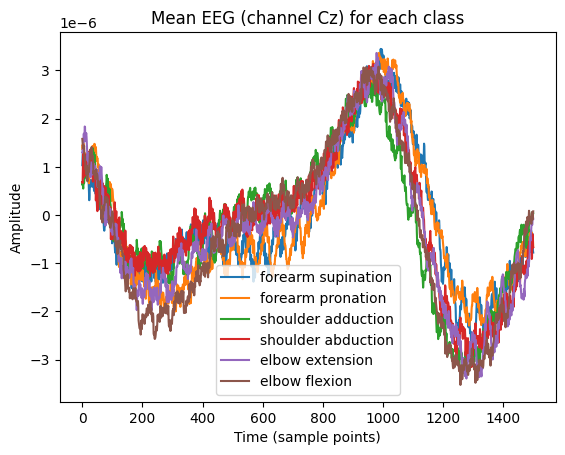

In [ ]:
#เช็คว่าค่าเฉลี่ยในแต่ละ class ต่างกันไหม (visualize signals)

mean_by_class = []
for i in range(6):  # สำหรับ 6 class
    idx = np.where(y_all == i)[0]
    mean_signal = X_all[idx].mean(axis=0)  # (channels, times)
    mean_by_class.append(mean_signal)

# ตัวอย่าง: พล็อต channel Cz (channel 7)
for i, signal in enumerate(mean_by_class):
    plt.plot(signal[7], label=list(label_map.keys())[i])
plt.legend()
plt.title("Mean EEG (channel Cz) for each class")
plt.xlabel("Time (sample points)")
plt.ylabel("Amplitude")
plt.show()


In [25]:
import numpy as np
from collections import Counter

label_counts = Counter(y_all)
for label_id, count in sorted(label_counts.items()):
    label_name = [k for k, v in label_map.items() if v == label_id][0]
    print(f"{label_name:20s}: {count} samples")


forearm supination  : 1800 samples
forearm pronation   : 1800 samples
shoulder adduction  : 1800 samples
shoulder abduction  : 1800 samples
elbow extension     : 1800 samples
elbow flexion       : 1800 samples
